# Limit Magnitude Calculator

In this notebook, catalogs of $ugrizY$ filters will'be loaded to calculate limit magnitude of the filters. But first, we have to do the photometric corrections by exposure time $t_{exp}$, airmass $X$, extinction coefficient $k$ and zero-point magnitude $ZP$ with the next formula:

\begin{equation*}
    m = m_{SEX}+2.5\log_{10}{t_{exp}}+ZP-kX
\end{equation*}

We're going to calculate Signal-to-Noise ratios for our objects with the formula:

\begin{equation*}
    \frac{S}{N}=\frac{F}{\sqrt{F+\sigma_b^2}}
\end{equation*}

where $F$ is the object flux in a $r=20$ $[pix]$ aperture, and $\sigma_b$ are the typical background flux fluctuations, measured also in $r=20$ $[pix]$ apertures.

## Catalog Edition Function

First, we create a catalog edition function to perform in one step the photometric corrections to the magnitudes, and also a cleaning of the catalog due to FLAGS and false detections.

In [1]:
from astropy.io.votable import parse_single_table,from_table,writeto
import numpy as np
import math
from astropy.io import fits
from astropy import units as u
import os
from astropy.table import QTable,vstack #to convert array into QTable format

import matplotlib.pyplot as plt
#%matplotlib notebook

work_dir = '/home/alex-cfrd/Escritorio/SEXtractor/'

In [2]:
def catalog_edit(catalog,decam_filter,ccd,exptime):
    os.chdir(work_dir+'filter_'+decam_filter+'/') #move to directory
    if ccd=='S':
        ccds_number=31
    elif ccd=='N':
        ccds_number=30
    sex_catalog = parse_single_table(catalog).to_table() #load catalog
    #CATALOG CLEANING
    sex_catalog.remove_rows(sex_catalog['FLUX_AUTO']<=0)
    sex_catalog.remove_rows(sex_catalog['FLUX_APER']<=0)
    sex_catalog.remove_rows(sex_catalog['MAG_AUTO']>=99)
    sex_catalog.remove_rows(sex_catalog['FLAGS']>4)
    #NEW COLUMNS
    sex_catalog.add_column(ccd,name='CCD',index=1) #add a ccd column (identify S and N)
    sex_catalog['CCD'].description = 'DECam CCD ID'
    if ccd=='S':
        sex_catalog.add_column(1,name='CCD_FAMILY',index=2)
    elif ccd=='N':
        sex_catalog.add_column(2,name='CCD_FAMILY',index=2)
    sex_catalog['CCD_FAMILY'].description = 'DECam CCD family ID (1:S;2:N)'
    sex_catalog.add_column(1.0*u.mag,name='ZP') #add a preliminary zeropoint column
    sex_catalog['ZP'].description = 'Photometric Zero-Point magnitude'
    sex_catalog.add_column(1.0*u.mag,name='ZP_ERR') #add a zeropoint error column
    sex_catalog['ZP_ERR'].description = 'Photometric error of Zero-Point magnitude'
    sex_catalog.add_column(1.0*u.mag,name='BACK_STD') #add a background fluctuations column
    sex_catalog['BACK_STD'].description = 'Typical background magnitude fluctuations'
    sex_catalog.add_column(1.0,name='k_COEFF') #add the extinction coefficients column
    sex_catalog['k_COEFF'].description = 'Extinction coefficient'
    sex_catalog.add_column(1.0*u.mag,name='TOTALERR_AUTO') #add the total photometric error column
    sex_catalog['TOTALERR_AUTO'].description = 'Quad sum of errors in AUTO magnitudes'
    sex_catalog.add_column(1.0,name='SNR') #add a signal-to-noise ratio column
    fluct = {'u':45.577454,'g':251.82860,'r':443.76776,'i':977.09856,'z':1834.9161,'Y':1977.9757} #dictionary with fluctuation for an r=10[pix] apertures
    sex_catalog['SNR'] = sex_catalog['FLUX_APER']/(np.sqrt(sex_catalog['FLUX_APER']+fluct[decam_filter]**2))
    sex_catalog['SNR'].description = 'S/N ratio for a 10 [pix] radius aperture'
    #modify the ccd column type
    for col in sex_catalog.itercols():
        if col.dtype.kind in 'SU':
            sex_catalog.replace_column(col.name, col.astype('object'))
    #LOAD THE PHOTOMETRIC CALIBRATION DATA
    phot_cal = np.genfromtxt(work_dir+'filter_'+decam_filter+'/ccd_photcal_'+decam_filter+'.txt')
    phot_cal = np.transpose(phot_cal)
    #USEFUL DATA
    airmass = phot_cal[1] #airmass column
    k_coeff = phot_cal[2] #extinction coeff column
    backstd = phot_cal[4] #background fluctuations column
    zp = phot_cal[5] #zeropoint column
    zp_err = phot_cal[6] #zeropoint error column
    #CHANGE NUMERATIONS
    for i in range(len(sex_catalog['NUMBER'])):
        sex_catalog[i]['NUMBER'] = i+1 #after clean the catalog, enumerate since 1
        if (sex_catalog[i]['EXT_NUMBER']==30) and ccd=='N': #CCD 30 is [N31]
            sex_catalog[i]['CCD'] += str(sex_catalog[i]['EXT_NUMBER']+1) #to the letter of CCD, add the number
        else:
            sex_catalog[i]['CCD'] += str(sex_catalog[i]['EXT_NUMBER']) #to the letter of CCD, add the number
    #EDIT MAGNITUDES
    if ccd=='S':
        photcal_index=0
    elif ccd=='N':
        photcal_index=31
    for i in range(1,ccds_number+1):
        cons = sex_catalog['EXT_NUMBER']==i #constraint
        #CORRECTIONS
        kX = k_coeff[i+photcal_index-1]*airmass[i+photcal_index-1] #extinction correction k*X
        ZP = zp[i+photcal_index-1] #zeropoint correction
        add_error = (backstd[i+photcal_index-1]**2)+(zp_err[i+photcal_index-1]**2) #added error
        #APPLY CORRECTIONS
        sex_catalog['MAG_APER'][cons] = sex_catalog['MAG_APER'][cons] + 2.5*math.log10(exptime) - kX + ZP
        sex_catalog['MAG_AUTO'][cons] = sex_catalog['MAG_AUTO'][cons] + 2.5*math.log10(exptime) - kX + ZP
        sex_catalog['TOTALERR_AUTO'][cons] = np.sqrt((sex_catalog['MAGERR_AUTO'][cons]**2) + add_error)
        sex_catalog['ZP'][cons] = ZP
        sex_catalog['ZP_ERR'][cons] = zp_err[i+photcal_index-1]
        sex_catalog['BACK_STD'][cons] = backstd[i+photcal_index-1]
        sex_catalog['k_COEFF'][cons] = k_coeff[i+photcal_index-1]
    #LIMIT MAGNITUDE FILTER
    #mag_limit = {'u':24.04,'g':22.05,'r':22.76,'i':22.38,'z':21.95,'Y':21.74} #dictionary with limit magnitudes
    #sex_catalog.remove_rows(sex_catalog['MAG_AUTO']>mag_limit[decam_filter])#remove m > mag_limit
    #DELETE S7 CCD
    if ccd=='S':
        sex_catalog.remove_rows(sex_catalog['EXT_NUMBER']==7)
    #CHANGE NUMERATIONS
    for i in range(len(sex_catalog['NUMBER'])):
        sex_catalog[i]['NUMBER'] = i+1 #after clean the catalog, enumerate since 1
        if (ccd=='N')&(sex_catalog[i]['EXT_NUMBER']==30):
            sex_catalog[i]['EXT_NUMBER'] += 1
    #APPEND FILTER TO COLNAMES
    for i in sex_catalog.colnames:
        sex_catalog[i].name += '_'+decam_filter
    #WRITE CHANGES
    #votable = from_table(sex_catalog) #convert table into a votable
    #writeto(votable,'new_'+catalog) #create a new votable catalogue
    return sex_catalog

## Merge catalog function

In [3]:
def merge_catalog(cat1,cat2,decam_filter):
    number_column = 'NUMBER_'+decam_filter
    merged_catalog = vstack([cat1,cat2])
    for i in range(len(merged_catalog[number_column])):
        merged_catalog[i][number_column] = i+1 #after merge the catalog, enumerate since 1
    votable = from_table(merged_catalog)
    writeto(votable,'merged_catalog_'+decam_filter+'.vot')
    return merged_catalog

## Filter $u$

In [4]:
Su = catalog_edit('Su.vot','u','S',700)
Nu = catalog_edit('Nu.vot','u','N',700)

In [5]:
filter_u = merge_catalog(Su,Nu,'u')

In [6]:
filter_u

NUMBER_u,CCD_u,CCD_FAMILY_u,EXT_NUMBER_u,FLUX_APER_u,FLUXERR_APER_u,MAG_APER_u,MAGERR_APER_u,FLUX_AUTO_u,FLUXERR_AUTO_u,MAG_AUTO_u,MAGERR_AUTO_u,X_IMAGE_u,Y_IMAGE_u,ALPHA_J2000_u,DELTA_J2000_u,MU_MAX_u,FLAGS_u,FWHM_IMAGE_u,CLASS_STAR_u,ZP_u,ZP_ERR_u,BACK_STD_u,k_COEFF_u,TOTALERR_AUTO_u,SNR_u
,,,,ct,ct,mag,mag,ct,ct,mag,mag,pix,pix,deg,deg,mag / arcsec2,,pix,,mag,mag,mag,,mag,
int32,object,int64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float64,float64,float64,float64,float64,float32
1,S1,1,1,133182.4,180.1792,17.49507,0.0015,138046.8,183.4685,17.45607,0.0014,1690.494,58.2985,62.8445531,-24.0141196,-11.0176,0,7.92,0.997,23.5339,0.0836,0.0037003,0.3209,0.08369356393814087,362.12845
2,S1,1,1,6489.923,39.92577,20.77557,0.0067,6392.414,39.66473,20.79197,0.0067,2351.983,36.1157,62.8422974,-24.0625655,-7.7227,0,13.37,0.204,23.5339,0.0836,0.0037003,0.3209,0.08394964039325714,70.11637
3,S1,1,1,924.5787,15.4269,22.89127,0.0181,1004.186,16.28189,22.80167,0.0176,843.9175,39.4465,62.8435288,-23.9522374,-5.1638,0,10.25,0.001,23.5339,0.0836,0.0037003,0.3209,0.08551264554262161,16.875126
4,S1,1,1,555.598,12.16908,23.44427,0.0238,921.5288,16.51827,22.894869,0.0195,2300.6733,28.9237,62.8417666,-24.0587979,-4.2982,0,12.9,0.0,23.5339,0.0836,0.0037003,0.3209,0.08592381328344345,10.827877
5,S1,1,1,1058.494,16.44998,22.74447,0.0169,1111.465,17.03019,22.69147,0.0166,1085.9814,22.0137,62.8420011,-23.9699108,-5.4121,0,9.59,0.008,23.5339,0.0836,0.0037003,0.3209,0.08531244099140167,18.902287
6,S1,1,1,327.9412,9.623221,24.01667,0.0319,330.5837,9.637509,24.007969,0.0317,600.5183,20.3785,62.8421472,-23.9344482,-4.5617,0,7.75,0.002,23.5339,0.0836,0.0037003,0.3209,0.08948487043380737,6.6867685
7,S1,1,1,406.788,10.57451,23.78277,0.0282,475.3817,11.78974,23.61357,0.0269,1894.0842,44.8209,62.8433441,-24.0290119,-4.275,0,14.11,0.0,23.5339,0.0836,0.0037003,0.3209,0.08789916336536407,8.161769
8,S1,1,1,260.5593,8.727449,24.266369,0.0364,291.644,9.320407,24.14407,0.0347,2098.5942,24.4053,62.8415665,-24.0439806,-3.9694,0,8.81,0.023,23.5339,0.0836,0.0037003,0.3209,0.09059107303619385,5.388861


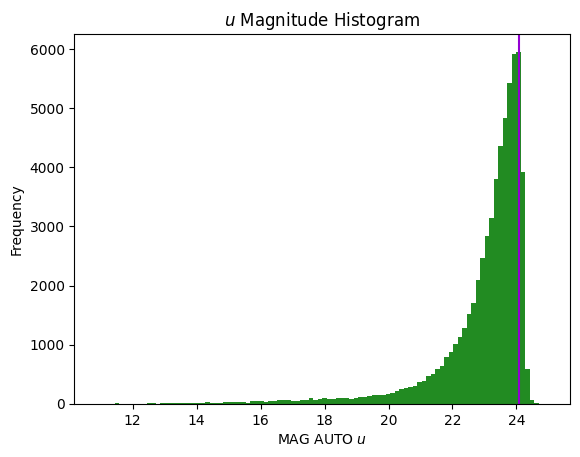

u Limit magnitude =  24.065162658691406


In [7]:
hist_u = plt.hist(filter_u['MAG_AUTO_u'][filter_u['SNR_u']>5],bins=100,color='forestgreen')

indice_inf = list(hist_u[0]).index(np.max(hist_u[0]))
indice_sup = indice_inf + 1
mag_limit_u = 0.5 * (hist_u[1][indice_inf]+hist_u[1][indice_sup]) #to find central value

plt.title('$u$ Magnitude Histogram')
plt.xlabel('MAG AUTO $u$')
plt.ylabel('Frequency')
plt.axvline(mag_limit_u,color='darkviolet')
plt.show()
print('u Limit magnitude = ',mag_limit_u)

## Filter $g$

In [30]:
Sg = catalog_edit('Sg.vot','g','S',300)
Ng = catalog_edit('Ng.vot','g','N',300)

In [31]:
filter_g = merge_catalog(Sg,Ng,'g')

In [32]:
filter_g

NUMBER_g,CCD_g,CCD_FAMILY_g,EXT_NUMBER_g,FLUX_APER_g,FLUXERR_APER_g,MAG_APER_g,MAGERR_APER_g,FLUX_AUTO_g,FLUXERR_AUTO_g,MAG_AUTO_g,MAGERR_AUTO_g,KRON_RADIUS_g,BACKGROUND_g,X_IMAGE_g,Y_IMAGE_g,ALPHA_J2000_g,DELTA_J2000_g,MU_MAX_g,FLAGS_g,FWHM_IMAGE_g,CLASS_STAR_g,ZP_g,ZP_ERR_g,BACK_STD_g,k_COEFF_g,TOTALERR_AUTO_g,SNR_g
,,,,ct,ct,mag,mag,ct,ct,mag,mag,,ct,pix,pix,deg,deg,mag / arcsec2,,pix,,mag,mag,mag,,mag,
int32,object,int64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float64,float64,float64,float64,float64,float32
1,S1,1,1,59.42885,112.2299,27.013103,2.0509,22016.77,225.7712,20.591202,0.0111,5.35,277.6776,374.2488,398.1924,62.8723204,-23.9172749,-8.332,2,21.45,0.007,25.4573,0.3312,0.0041868,0.2,0.3314124047756195,0.23587878
2,S1,1,1,17180.18,129.538,20.860504,0.0082,19283.71,172.2408,20.735104,0.0097,4.61,278.4917,855.66,40.7411,62.8435278,-23.9522085,-8.8662,0,8.38,0.095,25.4573,0.3312,0.0041868,0.2,0.33136847615242004,60.51542
3,S1,1,1,9283.869,121.8919,21.528803,0.0143,10043.13,157.0031,21.443403,0.017,5.2,278.0573,1098.5638,23.2642,62.8419964,-23.9699327,-8.1896,0,8.49,0.091,25.4573,0.3312,0.0041868,0.2,0.33166244626045227,34.431606
4,S1,1,1,14549.38,127.0459,21.041004,0.0095,14474.07,125.1808,21.046604,0.0094,4.25,278.2903,612.7645,21.6417,62.8421447,-23.934469,-9.3501,0,5.54,0.971,25.4573,0.3312,0.0041868,0.2,0.3313598036766052,52.10615
5,S1,1,1,2935.597,115.3724,22.778904,0.0427,2756.874,88.80125,22.847103,0.035,5.42,279.0399,60.6968,17.1325,62.8421491,-23.8941836,-7.8793,0,5.47,0.66,25.4573,0.3312,0.0041868,0.2,0.3330705165863037,11.396339
6,S1,1,1,2195.166,114.5668,23.094404,0.0567,2095.219,90.80443,23.145004,0.0471,7.55,276.8298,365.9295,16.2278,62.8418647,-23.9164541,-7.3512,0,6.13,0.456,25.4573,0.3312,0.0041868,0.2,0.33455848693847656,8.569846
7,S1,1,1,6045.07,118.57,21.994604,0.0213,5921.123,83.50708,22.017103,0.0153,3.57,277.3573,411.1392,48.7948,62.8444329,-23.9197716,-9.7564,3,11.26,0.854,25.4573,0.3312,0.0041868,0.2,0.33157965540885925,22.93641
8,S1,1,1,11561.54,124.1282,21.290604,0.0117,14387.31,209.8185,21.053204,0.0158,5.13,278.328,174.4775,59.5394,62.845448,-23.9025092,-7.8525,0,15.53,0.001,25.4573,0.3312,0.0041868,0.2,0.331603080034256,42.222633


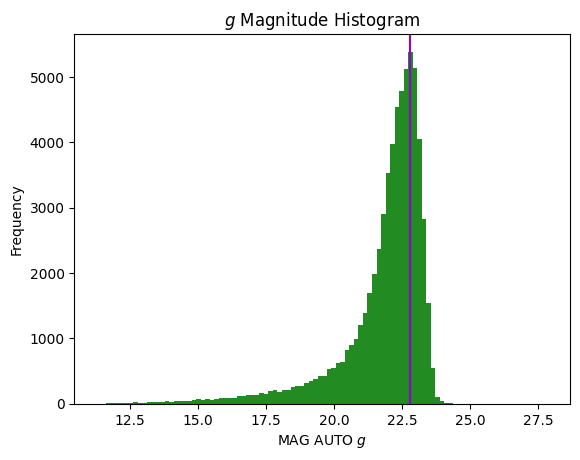

g Limit magnitude =  22.800201416015625


In [33]:
hist_g = plt.hist(filter_g['MAG_AUTO_g'][filter_g['SNR_g']>5],bins=100,color='forestgreen')

indice_inf = list(hist_g[0]).index(np.max(hist_g[0]))
indice_sup = indice_inf + 1
mag_limit_g = 0.5 * (hist_g[1][indice_inf]+hist_g[1][indice_sup]) #to find central value

plt.title('$g$ Magnitude Histogram')
plt.xlabel('MAG AUTO $g$')
plt.ylabel('Frequency')
plt.axvline(mag_limit_g,color='darkviolet')
plt.show()
print('g Limit magnitude = ',mag_limit_g)

## Filter $r$

In [12]:
Sr = catalog_edit('Sr.vot','r','S',300)
Nr = catalog_edit('Nr.vot','r','N',300)

In [13]:
filter_r = merge_catalog(Sr,Nr,'r')

In [14]:
filter_r

NUMBER_r,CCD_r,CCD_FAMILY_r,EXT_NUMBER_r,FLUX_APER_r,FLUXERR_APER_r,MAG_APER_r,MAGERR_APER_r,FLUX_AUTO_r,FLUXERR_AUTO_r,MAG_AUTO_r,MAGERR_AUTO_r,X_IMAGE_r,Y_IMAGE_r,ALPHA_J2000_r,DELTA_J2000_r,MU_MAX_r,FLAGS_r,FWHM_IMAGE_r,CLASS_STAR_r,ZP_r,ZP_ERR_r,BACK_STD_r,k_COEFF_r,TOTALERR_AUTO_r,SNR_r
,,,,ct,ct,mag,mag,ct,ct,mag,mag,pix,pix,deg,deg,mag / arcsec2,,pix,,mag,mag,mag,,mag,
int32,object,int64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float64,float64,float64,float64,float64,float32
1,S1,1,1,9944.056,64.95389,21.498203,0.0071,61100.45,170.3808,19.527002,0.003,166.4794,667.4186,62.9007752,-23.9031417,-8.2344,3,47.96,0.002,25.4058,0.2293,0.0027433,0.1,0.22933603823184967,21.863047
2,S1,1,1,17426.43,77.73158,20.889103,0.0048,108532.9,230.6197,18.903202,0.0023,620.2419,455.1248,62.8835672,-23.9362041,-8.8273,3,66.16,0.0,25.4058,0.2293,0.0027433,0.1,0.2293279469013214,37.639194
3,S1,1,1,8913.415,62.9929,21.617002,0.0077,12668.42,80.7248,21.235302,0.0069,1455.9258,49.2668,62.8506953,-23.9970757,-8.5546,3,20.42,0.049,25.4058,0.2293,0.0027433,0.1,0.22942018508911133,19.646076
4,S1,1,1,2138706.0,723.1324,15.666703,0.0004,2217951.0,737.3564,15.627204,0.0004,977.0059,86.3735,62.8539397,-23.9620835,-14.4732,4,6.22,0.998,25.4058,0.2293,0.0027433,0.1,0.22931675612926483,1399.4215
5,S1,1,1,80267.78,146.1331,19.230701,0.002,112839.0,187.6779,18.861004,0.0018,1510.9126,46.1345,62.8504116,-24.0010946,-10.0817,2,10.85,0.028,25.4058,0.2293,0.0027433,0.1,0.22932347655296326,152.4567
6,S1,1,1,205125.8,227.5481,18.212002,0.0012,210194.7,231.7895,18.185503,0.0012,1561.5574,53.834,62.8509945,-24.0048016,-11.9341,0,6.08,0.983,25.4058,0.2293,0.0027433,0.1,0.22931955754756927,323.5022
7,S1,1,1,39807.49,107.22,19.992203,0.0029,39900.35,107.4511,19.989702,0.0029,2392.223,43.3518,62.8495693,-24.0655879,-10.1699,0,6.11,0.979,25.4058,0.2293,0.0027433,0.1,0.2293347418308258,81.81471
8,S1,1,1,32859.11,99.00806,20.200502,0.0033,33128.77,100.1645,20.191603,0.0033,1786.4658,43.0383,62.8499885,-24.0212451,-9.9499,0,6.13,0.974,25.4058,0.2293,0.0027433,0.1,0.22934015095233917,68.54744


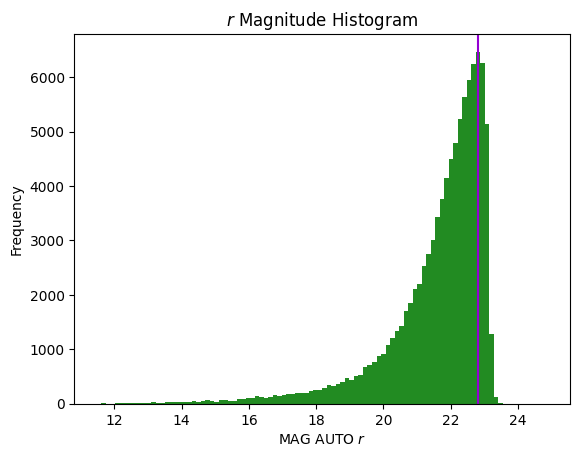

r Limit magnitude =  22.813602447509766


In [15]:
hist_r = plt.hist(filter_r['MAG_AUTO_r'][filter_r['SNR_r']>5],bins=100,color='forestgreen')

indice_inf = list(hist_r[0]).index(np.max(hist_r[0]))
indice_sup = indice_inf + 1
mag_limit_r = 0.5 * (hist_r[1][indice_inf]+hist_r[1][indice_sup]) #to find central value

plt.title('$r$ Magnitude Histogram')
plt.xlabel('MAG AUTO $r$')
plt.ylabel('Frequency')
plt.axvline(mag_limit_r,color='darkviolet')
plt.show()
print('r Limit magnitude = ',mag_limit_r)

## Filter $i$

In [34]:
Si = catalog_edit('Si.vot','i','S',360)
Ni = catalog_edit('Ni.vot','i','N',360)

In [35]:
filter_i = merge_catalog(Si,Ni,'i')

In [36]:
filter_i

NUMBER_i,CCD_i,CCD_FAMILY_i,EXT_NUMBER_i,FLUX_APER_i,FLUXERR_APER_i,MAG_APER_i,MAGERR_APER_i,FLUX_AUTO_i,FLUXERR_AUTO_i,MAG_AUTO_i,MAGERR_AUTO_i,X_IMAGE_i,Y_IMAGE_i,ALPHA_J2000_i,DELTA_J2000_i,MU_MAX_i,FLAGS_i,FWHM_IMAGE_i,CLASS_STAR_i,ZP_i,ZP_ERR_i,BACK_STD_i,k_COEFF_i,TOTALERR_AUTO_i,SNR_i
,,,,ct,ct,mag,mag,ct,ct,mag,mag,pix,pix,deg,deg,mag / arcsec2,,pix,,mag,mag,mag,,mag,
int32,object,int64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float64,float64,float64,float64,float64,float32
1,S1,1,1,101409.7,174.2599,19.220057,0.0019,106998.3,187.8513,19.161858,0.0019,1672.1515,53.5067,62.8633318,-24.0128304,-10.6741,0,7.91,0.036,25.4051,0.2455,0.0008474,0.06,0.2455088198184967,98.67805
2,S1,1,1,21533.52,104.4062,20.902456,0.0053,23475.09,127.4775,20.808756,0.0059,985.4495,36.6741,62.8624372,-23.9626975,-9.0099,0,7.87,0.02,25.4051,0.2455,0.0008474,0.06,0.24557234346866608,21.79382
3,S1,1,1,14937.56,96.39506,21.299557,0.007,15175.15,101.9507,21.282455,0.0073,1621.2395,28.3841,62.8613629,-24.009097,-8.8848,0,9.09,0.139,25.4051,0.2455,0.0008474,0.06,0.24560996890068054,15.169458
4,S1,1,1,16375.27,98.19169,21.199757,0.0065,16485.01,100.4146,21.192556,0.0066,1693.1959,22.2518,62.8608222,-24.0143441,-8.6789,0,8.24,0.011,25.4051,0.2455,0.0008474,0.06,0.24559016525745392,16.617174
5,S1,1,1,7294.107,86.21582,22.077856,0.0128,7387.767,89.60142,22.063955,0.0132,974.3614,24.7543,62.8614931,-23.9618804,-8.1447,0,6.64,0.208,25.4051,0.2455,0.0008474,0.06,0.24585607647895813,7.436713
6,S1,1,1,7697.448,86.80051,22.019356,0.0122,7628.8,88.82082,22.029156,0.0126,664.4599,18.961,62.8612176,-23.9392577,-7.9833,0,11.33,0.003,25.4051,0.2455,0.0008474,0.06,0.24582459032535553,7.8462954
7,S1,1,1,5511.421,83.66738,22.382055,0.0165,5527.191,83.98235,22.378956,0.0165,573.4022,18.094,62.861203,-23.9326114,-7.7858,0,6.73,0.16,25.4051,0.2455,0.0008474,0.06,0.24605531990528107,5.6243877
8,S1,1,1,15050.85,96.56424,21.291355,0.007,15664.37,110.3142,21.247955,0.0076,780.3793,37.7508,62.862647,-23.9477302,-8.7917,0,7.28,0.068,25.4051,0.2455,0.0008474,0.06,0.24561907351016998,15.283615


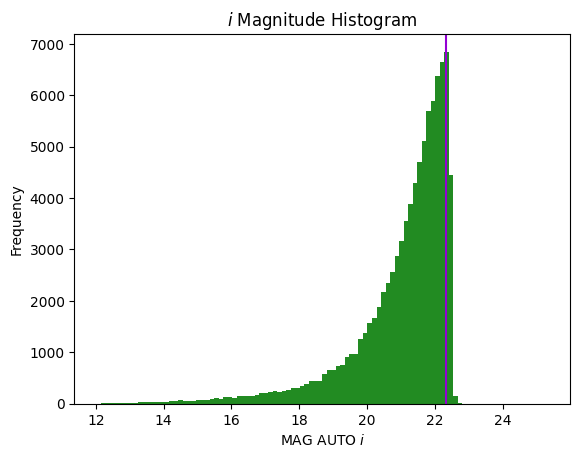

i Limit magnitude =  22.33888053894043


In [37]:
hist_i = plt.hist(filter_i['MAG_AUTO_i'][filter_i['SNR_i']>5],bins=100,color='forestgreen')

indice_inf = list(hist_i[0]).index(np.max(hist_i[0]))
indice_sup = indice_inf + 1
mag_limit_i = 0.5 * (hist_i[1][indice_inf]+hist_i[1][indice_sup]) #to find central value

plt.title('$i$ Magnitude Histogram')
plt.xlabel('MAG AUTO $i$')
plt.ylabel('Frequency')
plt.axvline(mag_limit_i,color='darkviolet')
plt.show()
print('i Limit magnitude = ',mag_limit_i)

## Filter $z$

In [38]:
Sz = catalog_edit('Sz.vot','z','S',360)
Nz = catalog_edit('Nz.vot','z','N',360)

In [39]:
filter_z = merge_catalog(Sz,Nz,'z')

In [40]:
filter_z

NUMBER_z,CCD_z,CCD_FAMILY_z,EXT_NUMBER_z,FLUX_APER_z,FLUXERR_APER_z,MAG_APER_z,MAGERR_APER_z,FLUX_AUTO_z,FLUXERR_AUTO_z,MAG_AUTO_z,MAGERR_AUTO_z,X_IMAGE_z,Y_IMAGE_z,ALPHA_J2000_z,DELTA_J2000_z,MU_MAX_z,FLAGS_z,FWHM_IMAGE_z,CLASS_STAR_z,ZP_z,ZP_ERR_z,BACK_STD_z,k_COEFF_z,TOTALERR_AUTO_z,SNR_z
,,,,ct,ct,mag,mag,ct,ct,mag,mag,pix,pix,deg,deg,mag / arcsec2,,pix,,mag,mag,mag,,mag,
int32,object,int64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float64,float64,float64,float64,float64,float32
1,S1,1,1,1612820.0,632.0518,15.946034,0.0004,1821017.0,688.0984,15.814235,0.0004,978.0602,114.1325,62.8536892,-23.9620577,-13.8943,0,11.57,0.873,25.1475,0.1349,0.0006869,0.07,0.13490234315395355,722.74097
2,S1,1,1,110267.4,182.6732,18.858936,0.0018,154192.6,254.6556,18.494835,0.0018,1512.0248,76.6924,62.8503409,-24.0011086,-10.425,0,10.69,0.028,25.1475,0.1349,0.0006869,0.07,0.13491375744342804,59.133453
3,S1,1,1,5494.889,88.54927,22.115135,0.0175,20078.46,157.4227,20.708237,0.0085,1274.7798,65.4717,62.8496007,-23.9837433,-7.54,2,12.66,0.001,25.1475,0.1349,0.0006869,0.07,0.13516926765441895,2.9921863
4,S1,1,1,13355.4,98.76981,21.150934,0.008,14986.6,143.751,21.025736,0.0104,1234.1799,31.4681,62.84691,-23.9807573,-7.9723,2,16.06,0.0,25.1475,0.1349,0.0006869,0.07,0.13530203700065613,7.264087
5,S1,1,1,13893.62,99.42316,21.108036,0.0078,15752.09,122.9549,20.971735,0.0085,2123.6362,31.6103,62.8463175,-24.0458528,-8.7813,0,6.78,0.228,25.1475,0.1349,0.0006869,0.07,0.13516926765441895,7.556227
6,S1,1,1,15560.06,101.4487,20.985035,0.0071,15643.49,100.9274,20.979237,0.007,1798.8574,30.5063,62.8464565,-24.0220807,-8.696,0,8.02,0.021,25.1475,0.1349,0.0006869,0.07,0.13508324325084686,8.460457
7,S1,1,1,7144.809,90.79553,21.830034,0.0138,7445.881,103.5078,21.785234,0.0151,1213.8607,20.2668,62.8460284,-23.9792655,-7.7608,0,7.65,0.004,25.1475,0.1349,0.0006869,0.07,0.13574421405792236,3.889682
8,S1,1,1,6630.474,90.043,21.911135,0.0147,7368.902,100.2672,21.796535,0.0148,1938.2325,15.2,62.8451366,-24.0322756,-7.9456,0,11.14,0.024,25.1475,0.1349,0.0006869,0.07,0.1357111781835556,3.6099498


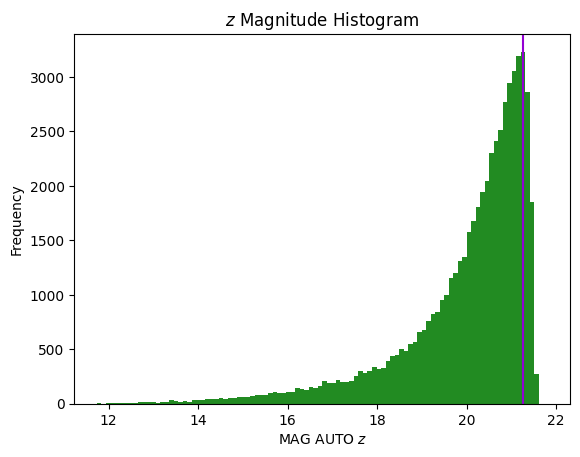

z Limit magnitude =  21.260772705078125


In [41]:
hist_z = plt.hist(filter_z['MAG_AUTO_z'][filter_z['SNR_z']>5],bins=100,color='forestgreen')

indice_inf = list(hist_z[0]).index(np.max(hist_z[0]))
indice_sup = indice_inf + 1
mag_limit_z = 0.5 * (hist_z[1][indice_inf]+hist_z[1][indice_sup]) #to find central value

plt.title('$z$ Magnitude Histogram')
plt.xlabel('MAG AUTO $z$')
plt.ylabel('Frequency')
plt.axvline(mag_limit_z,color='darkviolet')
plt.show()
print('z Limit magnitude = ',mag_limit_z)

## Filter $Y$

In [24]:
SY = catalog_edit('SY.vot','Y','S',700)
NY = catalog_edit('NY.vot','Y','N',700)

In [25]:
filter_Y = merge_catalog(SY,NY,'Y')

In [26]:
filter_Y

NUMBER_Y,CCD_Y,CCD_FAMILY_Y,EXT_NUMBER_Y,FLUX_APER_Y,FLUXERR_APER_Y,MAG_APER_Y,MAGERR_APER_Y,FLUX_AUTO_Y,FLUXERR_AUTO_Y,MAG_AUTO_Y,MAGERR_AUTO_Y,X_IMAGE_Y,Y_IMAGE_Y,ALPHA_J2000_Y,DELTA_J2000_Y,MU_MAX_Y,FLAGS_Y,FWHM_IMAGE_Y,CLASS_STAR_Y,ZP_Y,ZP_ERR_Y,BACK_STD_Y,k_COEFF_Y,TOTALERR_AUTO_Y,SNR_Y
,,,,ct,ct,mag,mag,ct,ct,mag,mag,pix,pix,deg,deg,mag / arcsec2,,pix,,mag,mag,mag,,mag,
int32,object,int64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float64,float64,float64,float64,float64,float32
1,S1,1,1,3996183.0,987.8911,14.521277,0.0003,4742646.0,1080.373,14.3352785,0.0002,1690.5061,55.0766,62.8445452,-24.0141231,-14.0846,0,14.0,0.98,24.0773,0.0761,0.0147177,0.1172,0.07751039415597916,1421.0074
2,S1,1,1,60210.12,129.8764,19.07618,0.0023,63558.79,139.2063,19.017479,0.0024,1176.5858,58.7747,62.8451368,-23.9765541,-9.87,0,9.26,0.029,24.0773,0.0761,0.0147177,0.1172,0.07754728198051453,30.208712
3,S1,1,1,24113.89,89.84241,20.06968,0.004,30147.86,115.1216,19.827278,0.0041,162.0074,55.9766,62.8454711,-23.9024309,-8.3486,0,13.76,0.001,24.0773,0.0761,0.0147177,0.1172,0.07761849462985992,12.1538
4,S1,1,1,33365.66,101.6348,19.717178,0.0033,40976.05,129.0244,19.49408,0.0034,1894.5178,41.9493,62.8433604,-24.0290438,-8.987,0,12.53,0.018,24.0773,0.0761,0.0147177,0.1172,0.07758466899394989,16.797117
5,S1,1,1,102808.3,165.0777,18.495277,0.0017,107016.0,172.2191,18.451778,0.0017,1937.4984,44.215,62.84351,-24.0321907,-10.6377,2,8.23,0.071,24.0773,0.0761,0.0147177,0.1172,0.07752877473831177,51.30678
6,S1,1,1,6618.327,61.73884,21.473478,0.0101,7496.473,77.40109,21.338278,0.0112,1926.8422,30.4674,62.8424216,-24.0314045,-7.533,3,8.59,0.001,24.0773,0.0761,0.0147177,0.1172,0.0783151388168335,3.343184
7,S1,1,1,46020.96,115.8133,19.367977,0.0027,47420.34,121.6064,19.335478,0.0028,1347.7268,41.7394,62.8436851,-23.989053,-9.7845,0,8.21,0.037,24.0773,0.0761,0.0147177,0.1172,0.07756069302558899,23.13105
8,S1,1,1,106155.6,167.5282,18.460478,0.0017,124942.1,190.9711,18.283577,0.0017,843.248,36.5572,62.8435379,-23.9521876,-10.3151,0,10.09,0.029,24.0773,0.0761,0.0147177,0.1172,0.07752877473831177,52.955196


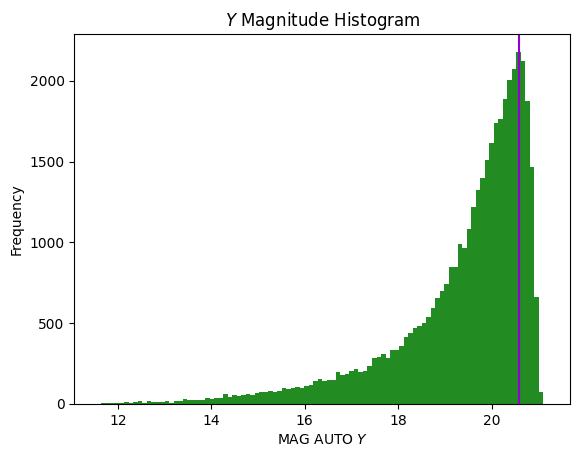

Y Limit magnitude =  20.577388763427734


In [27]:
hist_Y = plt.hist(filter_Y['MAG_AUTO_Y'][filter_Y['SNR_Y']>5],bins=100,color='forestgreen')

indice_inf = list(hist_Y[0]).index(np.max(hist_Y[0]))
indice_sup = indice_inf + 1
mag_limit_Y = 0.5 * (hist_Y[1][indice_inf]+hist_Y[1][indice_sup]) #to find central value

plt.title('$Y$ Magnitude Histogram')
plt.xlabel('MAG AUTO $Y$')
plt.ylabel('Frequency')
plt.axvline(mag_limit_Y,color='darkviolet')
plt.show()
print('Y Limit magnitude = ',mag_limit_Y)

Finally, our limit magnitudes are:

In [29]:
print('u <',mag_limit_u)
print('g <',mag_limit_g)
print('r <',mag_limit_r)
print('i <',mag_limit_i)
print('z <',mag_limit_z)
print('Y <',mag_limit_Y)

u < 24.065162658691406
g < 22.583145141601562
r < 22.813602447509766
i < 22.346040725708008
z < 21.260883331298828
Y < 20.577388763427734
